In [7]:
import os
import cv2 
import math
import keras
import skimage
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras import Model, Input, regularizers
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
x_train_linneaus = []
y_train_linneaus = []
factor = 2
image_folder = '/content/drive/MyDrive/202111040_DL/Project/Linneaus/Linnaeus 5 128X128/train'
for dir1 in os.listdir(image_folder):
  for file in os.listdir(os.path.join(image_folder, dir1)):
  
      image_path= os.path.join(image_folder, dir1,  file)
      image= plt.imread( image_path)
      image = image.astype('float32')
      y_train_linneaus.append(image)

      # Find old and new image dimensions
      h, w, c = image.shape
      new_height = h // factor
      new_width = w // factor

      # Resize down the image
      image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
      
      # Resize up the image
      image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
      
      x_train_linneaus.append(image)

In [12]:
x_train_linneaus = np.asarray(x_train_linneaus)
y_train_linneaus = np.asarray(y_train_linneaus)

In [13]:
print("The shape of X Train is: ", x_train_linneaus.shape)
print("The shape of Y Train is: ", y_train_linneaus.shape)

The shape of X Train is:  (6000, 128, 128, 3)
The shape of Y Train is:  (6000, 128, 128, 3)


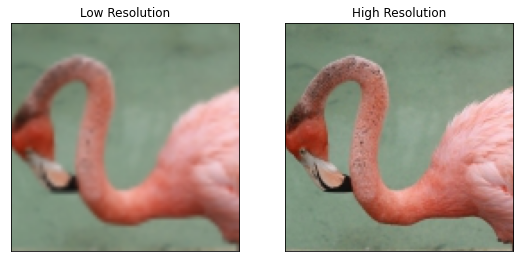

In [63]:
idx = 2163
# display images as subplots
fig, axs = plt.subplots(1, 2,figsize=(9,9))
axs[0].imshow(x_train_linneaus[idx].astype(int))
axs[0].set_title('Low Resolution')
axs[1].imshow(y_train_linneaus[idx].astype(int))
axs[1].set_title('High Resolution')
# remove the x and y ticks
for ax in axs:
  ax.set_xticks([])
  ax.set_yticks([])

In [ ]:
x_test_linneaus = []
y_test_linneaus = []
factor = 2
image_folder = '/content/drive/MyDrive/202111040_DL/Project/Linneaus/Linnaeus 5 128X128/test'
for dir1 in os.listdir(image_folder):
  for file in os.listdir(os.path.join(image_folder, dir1)):
  
      image_path= os.path.join(image_folder, dir1,  file)
      image= plt.imread( image_path)
      image = image.astype('float32')
      y_test_linneaus.append(image)

      # Find old and new image dimensions
      h, w, c = image.shape
      new_height = h // factor
      new_width = w // factor

      # Resize down the image
      image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
      
      # Resize up the image
      image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
      
      x_test_linneaus.append(image)

In [ ]:
x_test_linneaus = np.asarray(x_test_linneaus)
y_test_linneaus = np.asarray(y_test_linneaus)
print("The shape of X Test is: ", x_test_linneaus.shape)
print("The shape of Y Test is: ", y_test_linneaus.shape)

The shape of X Test is:  (2000, 128, 128, 3)
The shape of Y Test is:  (2000, 128, 128, 3)


In [ ]:
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

In [ ]:
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1] * target.shape[2])
    
    return err

In [ ]:
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

In [ ]:
Input_img = Input(shape=(128, 128, 3))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])
# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

In [ ]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

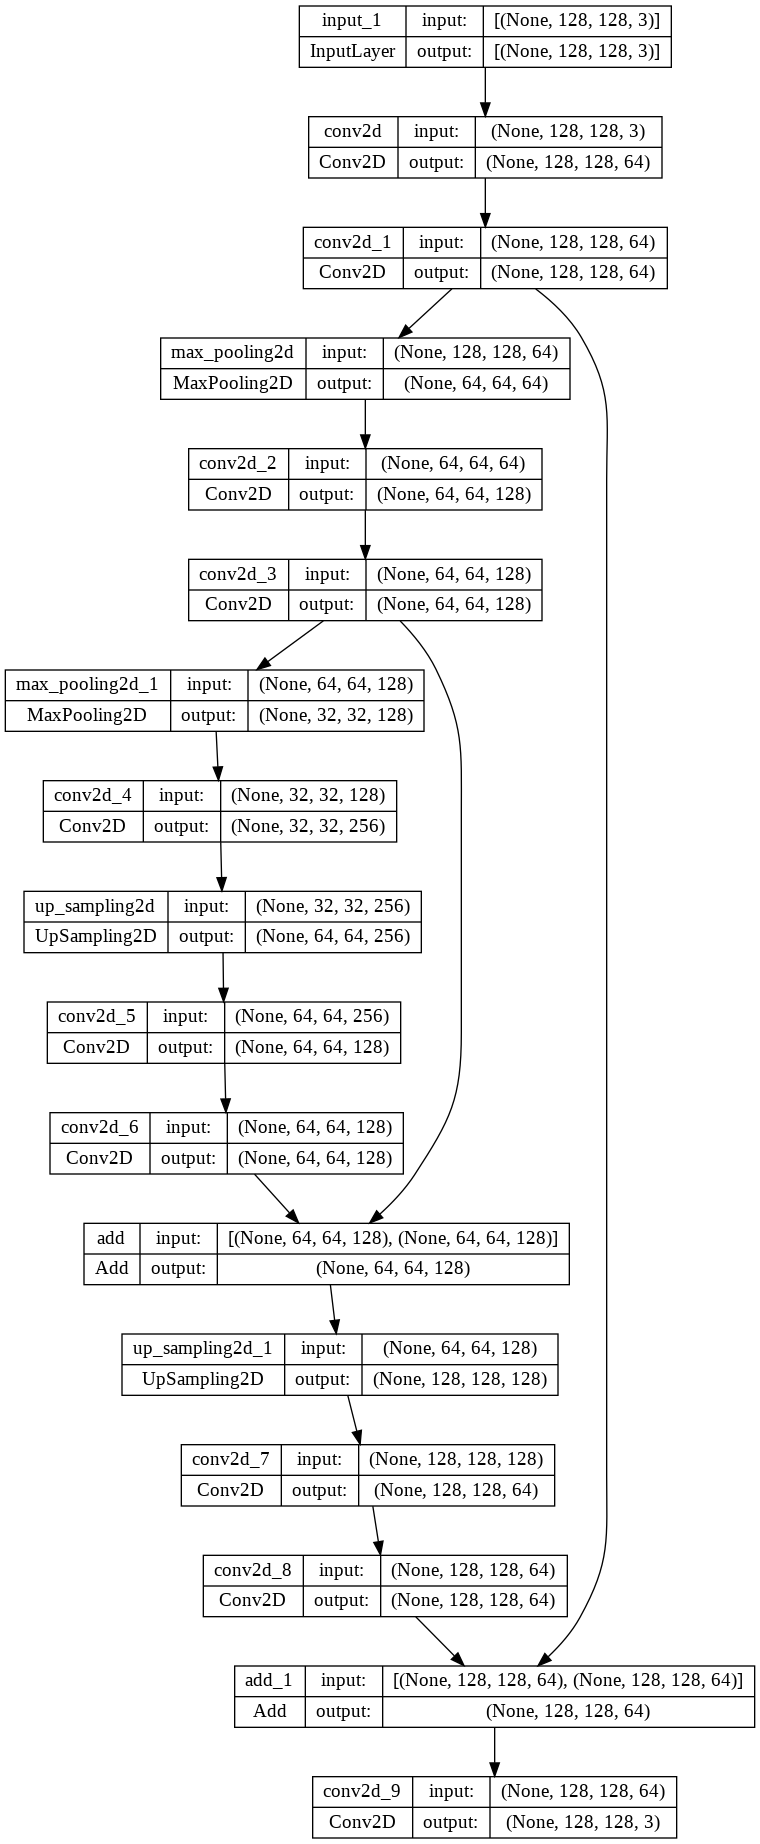

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='autoencoder_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_checkpoint =  ModelCheckpoint('/content/drive/MyDrive/202111040_DL/Project/superResolution_checkpoint3.h5', save_best_only = True)

In [ ]:
history = autoencoder.fit(x_train_linneaus,y_train_linneaus,
            epochs=50,callbacks=[model_checkpoint])

Epoch 1/50
73/73 [==============================] - 52s 478ms/step - loss: 2936.9851 - mean_squared_error: 2936.9849
Epoch 2/50
73/73 [==============================] - 33s 458ms/step - loss: 160.0077 - mean_squared_error: 160.0076
Epoch 3/50
73/73 [==============================] - 33s 459ms/step - loss: 130.6911 - mean_squared_error: 130.6910
Epoch 4/50
73/73 [==============================] - 34s 459ms/step - loss: 121.2814 - mean_squared_error: 121.2814
Epoch 5/50
73/73 [==============================] - 34s 459ms/step - loss: 115.9558 - mean_squared_error: 115.9558
Epoch 6/50
73/73 [==============================] - 34s 460ms/step - loss: 112.8125 - mean_squared_error: 112.8124
Epoch 7/50
73/73 [==============================] - 34s 460ms/step - loss: 111.2138 - mean_squared_error: 111.2138
Epoch 8/50
73/73 [==============================] - 34s 460ms/step - loss: 109.6293 - mean_squared_error: 109.6292
Epoch 9/50
73/73 [==============================] - 34s 461ms/step - loss: 108

In [ ]:
autoencoder.save('/content/drive/MyDrive/202111040_DL/Project/srcnn.h5')

In [ ]:
autoencoder = keras.models.load_model('/content/drive/MyDrive/202111040_DL/Project/srcnn.h5')

In [ ]:
prediction = autoencoder.predict(x_test_linneaus)

63/63 [==============================] - 5s 76ms/step


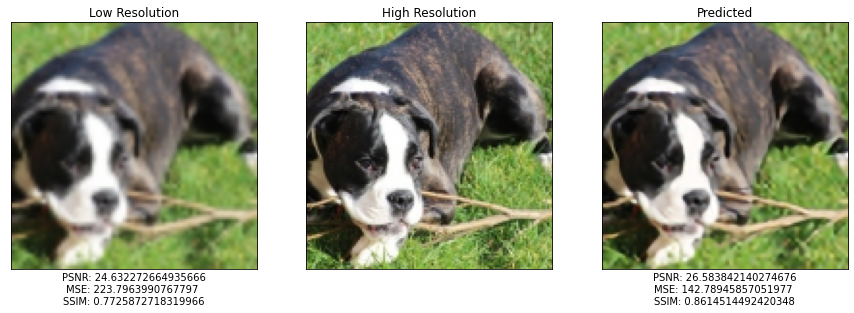

In [ ]:
idx1 = 1040
scores_lr = compare_images(x_test_linneaus[idx1], y_test_linneaus[idx1])
scores_prd = compare_images(prediction[idx1], y_test_linneaus[idx1])
# display images as subplots
fig, axs = plt.subplots(1, 3,figsize=(15,15))
axs[0].imshow(x_test_linneaus[idx1].astype(int))
axs[0].set_title('Low Resolution')
axs[0].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores_lr[0], scores_lr[1], scores_lr[2]))
axs[1].imshow(y_test_linneaus[idx1].astype(int))
axs[1].set_title('High Resolution')
axs[2].imshow(prediction[idx1].astype(int))
axs[2].set_title('Predicted')
axs[2].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores_prd[0], scores_prd[1], scores_prd[2]))
# remove the x and y ticks
for ax in axs:
  ax.set_xticks([])
  ax.set_yticks([])

In [ ]:
total_ssim = 0
for i in range(0,prediction.shape[0]) :
  total_ssim += ssim(prediction[i],y_test_linneaus[i],multichannel=True)
avg_ssim = total_ssim/prediction.shape[0]

In [ ]:
print("The average SSIM: ",avg_ssim)

The average SSIM:  0.8590183451196399
